In [1]:
from IPython.display import display, SVG
from typing import Optional, Sequence
import dataclasses
import math

from typesetting import Font, Glyph, ParagraphItem, ParagraphItemType
from typesetting.cairo import context_show_text_glyphs

Source:

http://www.eprg.org/G53DOC/pdfs/knuth-plass-breaking.pdf

In [2]:
from faker import Faker
import textwrap
import hyphen
import uniseg.wordbreak

SOFT_HYPHEN = "\N{SOFT HYPHEN}"
def hyphenate(text: str):
    hyphenator = hyphen.Hyphenator()
    words = []
    for word in uniseg.wordbreak.words(text):
        syllables = hyphenator.syllables(word) if len(word) < 100 else [word]
        if "".join(syllables) == word:
            words.append(SOFT_HYPHEN.join(syllables))
        else:
            words.append(word)
    return "".join(words)

Faker.seed(0xdeadbeef)
lorem = hyphenate("".join([
    "Difficult Quick Foxes with 1034 boxes. ",
    Faker(["la"]).paragraph(50)
]))
print(f"Generated lorem ipsum:\n\n{textwrap.fill(lorem, 72)}")
print(f"\nRepr of first part:\n{textwrap.shorten(lorem, 72)!r}")

Generated lorem ipsum:

Dif­fi­cult Quick Foxes with 1034 boxes. Iusto no­bis in­cidunt nos­trum
quas oc­cae­cati. Ex fa­cilis pariatur quam rep­re­hen­derit fugit
magni. Eius do­lo­rum do­lo­rum maxime hic. Il­lum nemo neque
con­secte­tur volup­ta­tum per­spi­ci­atis ab. Op­tio mo­les­tias no­bis
er­ror facere libero. Harum ip­sam na­tus rep­re­hen­derit do­lore
as­sumenda unde. Tene­tur ab cor­rupti rem modi quia fuga. Ali­quam
pariatur do­lores esse con­secte­tur ipsa fugit. Beatae per­fer­endis
alias deb­itis. Eius mi­nus volup­tas amet quis quae. Fuga cor­rupti
lau­dan­tium in­cidunt in ipsa tem­pora. Unde ver­i­tatis quia iure
volup­tatem fugit culpa. Min­ima ex­cep­turi saepe vero sit of­fi­cia.
At eum rep­re­hen­derit ver­i­tatis quos. Neque pos­simus mo­les­tiae
ver­i­tatis mo­les­tias autem fu­giat min­ima. Lau­dan­tium sapi­ente
alias illo to­tam. Of­fi­cia sed so­luta harum in­cidunt. Nemo
volup­tat­i­bus mag­nam ducimus la­bore of­ficiis. Earum modi sunt
ex­pli­cabo to­tam

In [3]:
rm_face_path = "EBGaramond-VariableFont_wght.ttf"
rm_size = 12
rm_font = Font(rm_face_path, (rm_size, rm_size), features=["onum"])
rm_font.freetype_face.set_var_named_instance("Medium")

In [4]:
import uniseg.linebreak

lorem_feasible_breakpoints = set(uniseg.linebreak.line_break_boundaries(lorem))

rm_hyphen_glyphs = rm_font.shape("-")
rm_hyphen_width = sum(g.x_advance for g in rm_hyphen_glyphs)
lorem_glyphs = rm_font.shape(lorem)

lorem_glyphs[:50]

[Glyph(index=22, cluster='D', cluster_code_point_index=0, x_advance=9.09375, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=481, cluster='i', cluster_code_point_index=1, x_advance=3.15625, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=1000, cluster='f', cluster_code_point_index=2, x_advance=9.8125, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=2553, cluster='f', cluster_code_point_index=2, x_advance=0.0, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=2553, cluster='\xad', cluster_code_point_index=6, x_advance=0.0, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=449, cluster='c', cluster_code_point_index=7, x_advance=4.890625, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=538, cluster='u', cluster_code_point_index=8, x_advance=6.421875, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=497, cluster='l', cluster_code_point_index=9, x_advance=3.015625, y_advance=0.0, x_offset=0.0, y_offset=0.0),
 Glyph(index=535, cluster

In [5]:
SOFT_HYPHEN_PENALTY=50
INFINITY = 1000

para_items: list[ParagraphItem] = []
para_item_to_glyphs: dict[ParagraphItem, Sequence[Glyph]] = {}
for glyph in lorem_glyphs:
    item = None
    if glyph.cluster_code_point_index + len(glyph.cluster) in lorem_feasible_breakpoints:
        if glyph.cluster == SOFT_HYPHEN:
            item = ParagraphItem(
                item_type=ParagraphItemType.PENALTY,
                width=rm_hyphen_width,
                penalty=SOFT_HYPHEN_PENALTY,
                flagged=True,
            )
        elif glyph.cluster.isspace():
            item = ParagraphItem(
                item_type=ParagraphItemType.GLUE,
                width=glyph.x_advance,
                shrinkability=0.5*glyph.x_advance,
                stretchability=2.0*glyph.x_advance
            )
        else:
            item = ParagraphItem(
                item_type=ParagraphItemType.PENALTY,
                width=glyph.x_advance,
            )
    else:
        item = ParagraphItem(
            item_type=ParagraphItemType.BOX,
            width=glyph.x_advance
        )

    if item is not None:
        para_items.append(item)
        if glyph.cluster == SOFT_HYPHEN:
            para_item_to_glyphs[item] = rm_hyphen_glyphs
        else:
            para_item_to_glyphs[item] = [glyph]

# Add finishing glue and forced break
para_items.append(ParagraphItem(
    item_type=ParagraphItemType.GLUE,
    stretchability=INFINITY,
))
para_items.append(ParagraphItem(
    item_type=ParagraphItemType.PENALTY,
    penalty=-INFINITY,
    flagged=True,
))

In [6]:
print("First few items:")
print("\n".join(textwrap.indent(f"{item!r}", "  ") for item in para_items[:10]))
print("Final few items:")
print("\n".join(textwrap.indent(f"{item!r}", "  ") for item in para_items[-10:]))

First few items:
  ParagraphItem(item_type=<ParagraphItemType.BOX: 1>, width=9.09375, stretchability=0.0, shrinkability=0.0, penalty=0.0, flagged=False)
  ParagraphItem(item_type=<ParagraphItemType.BOX: 1>, width=3.15625, stretchability=0.0, shrinkability=0.0, penalty=0.0, flagged=False)
  ParagraphItem(item_type=<ParagraphItemType.BOX: 1>, width=9.8125, stretchability=0.0, shrinkability=0.0, penalty=0.0, flagged=False)
  ParagraphItem(item_type=<ParagraphItemType.BOX: 1>, width=0.0, stretchability=0.0, shrinkability=0.0, penalty=0.0, flagged=False)
  ParagraphItem(item_type=<ParagraphItemType.PENALTY: 3>, width=3.46875, stretchability=0.0, shrinkability=0.0, penalty=50, flagged=True)
  ParagraphItem(item_type=<ParagraphItemType.BOX: 1>, width=4.890625, stretchability=0.0, shrinkability=0.0, penalty=0.0, flagged=False)
  ParagraphItem(item_type=<ParagraphItemType.BOX: 1>, width=6.421875, stretchability=0.0, shrinkability=0.0, penalty=0.0, flagged=False)
  ParagraphItem(item_type=<Parag

In [7]:
from collections import namedtuple

RunningSum = namedtuple("RunningSum", ["natural", "minimum", "maximum"])
def para_item_running_sums(para_items: Sequence[ParagraphItem]) -> Sequence[RunningSum]:
    previous_sum = RunningSum(0, 0, 0)
    sums = []
    for item in para_items:
        previous_sum = RunningSum(
            natural=previous_sum.natural + item.width,
            minimum=previous_sum.minimum + item.width - item.shrinkability,
            maximum=previous_sum.maximum + item.width + item.stretchability
        )
        sums.append(previous_sum)
    return sums

In [12]:
def greedy(para_items: Sequence[ParagraphItem], line_width: float):
    sums = para_item_running_sums(para_items)
    current_start_idx = 0
    line_end_indxs = []
    for item_idx, item in enumerate(para_items):
        # Don't break lines at boxes.
        if item.item_type == ParagraphItemType.BOX:
            continue

        # Forced break
        if item.penalty <= -INFINITY:
            line_end_indxs.append(item_idx)
            current_start_idx = item_idx + 1
            continue
            
        line_max = sums[item_idx].maximum - sums[current_start_idx].maximum
        if line_max < line_width:
            continue
        line_natural = sums[item_idx].natural - sums[current_start_idx].natural
        if line_natural > line_width:
            line_end_indxs.append(item_idx)
            current_start_idx = item_idx + 1
    return line_end_indxs

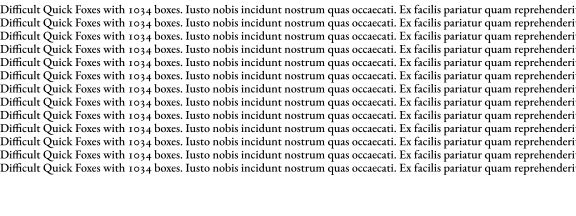

In [18]:
import cairo
import io

paper_size = (8 * 72, 3 * 72)

line_gap = rm_font.em_size[1] * 1.1
with io.BytesIO() as svg_file:
    with cairo.SVGSurface(svg_file, paper_size[0], paper_size[1]) as surface:
        ctx = cairo.Context(surface)

        # Fill background
        ctx.rectangle(0, 0, paper_size[0], paper_size[1])
        ctx.set_source_rgb(1, 1, 1)
        ctx.fill()

        # Render lines
        ctx.set_source_rgb(0, 0, 0)
        line_start_idx = 0
        for line_idx, line_end_idx in enumerate(greedy(para_items, paper_size[0])):
            ctx.move_to(0, (line_idx + 1) * line_gap)
            line_items = para_items[line_start_idx:line_end_idx]
            line_glyphs = []
            for item_idx, item in enumerate(line_items):
                if item.item_type == ParagraphItemType.PENALTY and item_idx != len(line_items) - 1:
                    continue
                item_glyphs = para_item_to_glyphs.get(item, [])
                line_glyphs.extend(item_glyphs)
                
            context_show_text_glyphs(ctx, rm_font, line_glyphs)
            line_start_idx = line_end_idx

    svg_data = svg_file.getvalue()
    
display(SVG(svg_data))